### Declare libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import os
from sklearn.model_selection import GridSearchCV, train_test_split,cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import QuantileTransformer,RobustScaler
from sklearn.svm import SVR
from xgboost import DMatrix,XGBRegressor, train

### Declare functions made by my own

In [2]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def train_metrics(X,y,n_cv, metrics, model):
    scores = cross_validate(model, X, y, scoring=metrics, cv=n_cv,return_train_score=False)
    # print scores
    #print('Mean train R2 of the training with cross validation: %.3f (%.3f)' % (scores['train_r2'].mean(), scores['train_r2'].std()) )
    print('Mean test R2 of the training with cross validation: %.3f (%.3f)' % (scores['test_r2'].mean(), scores['test_r2'].std()) )
    #print('Mean train MSE vof the training with cross validation: %.3f (%.3f)' % (scores['train_mse'].mean(), scores['train_mse'].std()) )
    print('Mean test MSE of the training with cross validation: %.3f (%.3f)' % (scores['test_mse'].mean(), scores['test_mse'].std()) )
    #print('Mean train MAE of the training with cross validation: %.3f (%.3f)' % (scores['train_mae'].mean(), scores['train_mae'].std()) )
    print('Mean test MAE of the training with cross validation: %.3f (%.3f)' % (scores['test_mae'].mean(), scores['test_mae'].std()) )
    # plot of train and test scores of the K-folds
    values = np.arange(1,n_cv+1)
    #plt.plot(values, scores['train_mae'], '-o', label='Train MAE of the training with cross validation')
    plt.plot(values, scores['test_mae'], '-o', label='Test MAE of the training with cross validation')
    plt.title('MSE of the training with cross validation in each k-fold')
    plt.legend()
    plt.show()
    return scores

def show_test_metrics(X_train,y_train,y_test,model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
    error = abs(y_pred-y_test)
    print(error.describe())
    sns.scatterplot(y=y_test, x=y_pred,legend=True)
    return model,y_pred, error

### Load data and transform


The task done here where: 

* Set folder location of the data
* Load the data
* Select the variables that i am going to use
* Apply the drop of NA over the new dataset with the selected variables
* extract the target variables (total minutes) to variable y
* extract the explaining variables to variable X

In [3]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')
# Loading pre-processed dataset
model_data = pd.read_csv('interim/model_data.csv', sep=';')
model_data['is_weighted'] = model_data.KG.apply(lambda x: 1 if x>0 else 0)
model_data['on_demand'] = model_data.on_demand.apply(lambda x: 1 if x>0 else 0)
col_names = ['on_demand', 'is_weighted','UN','picking_speed', 'order_stores_distance',
             'seniority','total_minutes',
            ]                    
X = model_data[col_names]
X.dropna(inplace=True)
y = X.total_minutes
X.drop('total_minutes', axis=1, inplace=True)
X = pd.get_dummies(X)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
on_demand,7983,0,0.0
is_weighted,7983,0,0.0
UN,7983,0,0.0
picking_speed,7983,0,0.0
order_stores_distance,7983,0,0.0
seniority_ADVANCED,7983,0,0.0
seniority_BEGINNER,7983,0,0.0
seniority_INTERMEDIATE,7983,0,0.0
seniority_REVIEW,7983,0,0.0


### Split the data into train (75%) and test (25%)

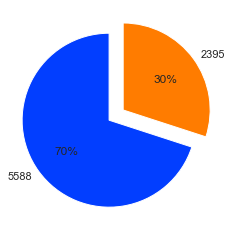

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

In [5]:
metrics = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error",
           "r2" : "r2"
         }
n_cv = 10

### Predicting intervals with Random Forest Regressor

<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html>

#### train with cross-validation

<https://scikit-learn.org/stable/modules/cross_validation.html>

Mean test R2 of the training with cross validation: 0.441 (0.034)
Mean test MSE of the training with cross validation: -676.289 (57.845)
Mean test MAE of the training with cross validation: -19.628 (0.537)


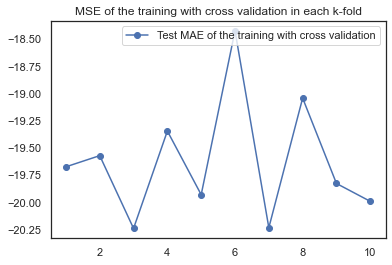

In [6]:
regr = RandomForestRegressor(n_jobs=-1,
                             n_estimators=500,
                             max_depth=6,
                             min_samples_leaf=0.01,
                             min_samples_split=0.01,
                            )
scores = train_metrics(X = X_train,y = y_train,n_cv=n_cv, metrics = metrics, model = regr)

#### train and report test metrics

1.0
The mean squared error (MSE) on test set: 667.6569
The mean absolute error (MAE) on test set: 19.5736
count    2395.000000
mean       19.573612
std        16.871557
min         0.014974
25%         8.073421
50%        15.381306
75%        26.546829
max       144.024623
Name: total_minutes, dtype: float64


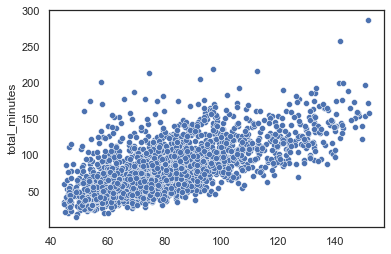

In [7]:
model,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = regr)

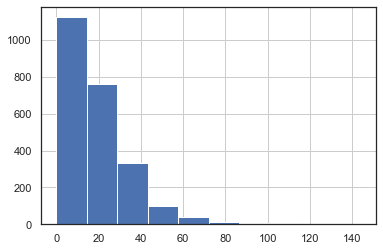

In [8]:
error.hist();

### Predicting intervals with Gradient Boosting Regression with quantils

Using GBR to predict intervals on 5%, 50% and 95%


<https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb>

<https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py>

<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor>

#### train with cross-validation

<https://scikit-learn.org/stable/modules/cross_validation.html>

Mean test R2 of the training with cross validation: 0.445 (0.037)
Mean test MSE of the training with cross validation: -671.175 (60.714)
Mean test MAE of the training with cross validation: -18.720 (0.486)


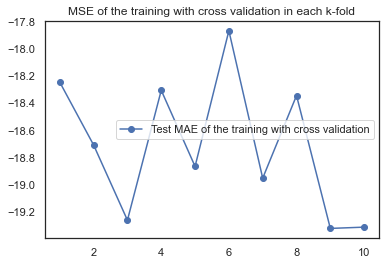

In [9]:
gbr_params = dict(
    learning_rate=0.1,
    n_estimators=150,
    max_depth=2,
    min_samples_leaf=0.01,
    min_samples_split=0.01,
)
gbr  = GradientBoostingRegressor(loss="quantile", alpha=0.5 , **gbr_params)
scores = train_metrics(X = X_train,y = y_train,n_cv=n_cv, metrics = metrics, model = gbr)

#### Train model and predict on the test data to report metrics

0.8655532359081419
The mean squared error (MSE) on test set: 675.0241
The mean absolute error (MAE) on test set: 18.8836


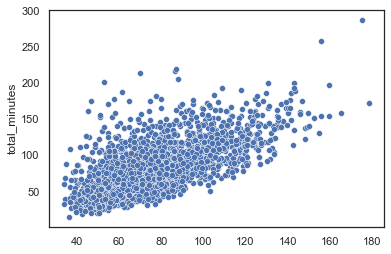

In [10]:
all_models = {}
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **gbr_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)
y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)
y_med = all_models["q 0.50"].predict(X_test)
print(sum((y_upper>=y_test) & (y_lower<=y_test))/ len(y_test))
mse = mean_squared_error(y_test,y_med )
mae = mean_absolute_error(y_test, y_med)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=y_med,legend=True);

count    2395.000000
mean       18.883597
std        17.848442
min         0.009552
25%         6.925169
50%        14.007699
75%        24.890134
max       148.539452
Name: total_minutes, dtype: float64


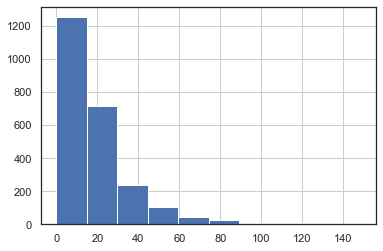

In [11]:
error = abs(y_med-y_test)
print(error.describe())
error.hist();

### Scikit-Learn Interface for XGboost

Using the cost functions mae and mse  from scikit-learn out of the box

<https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html>

<https://machinelearningmastery.com/xgboost-for-regression/>

#### train model with cross-validation

Mean test R2 of the training with cross validation: 0.463 (0.042)
Mean test MSE of the training with cross validation: -648.705 (56.588)
Mean test MAE of the training with cross validation: -19.182 (0.434)


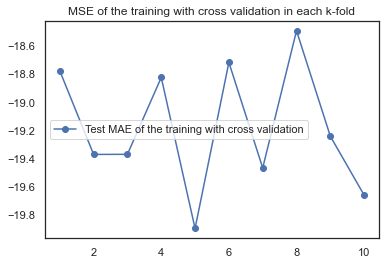

In [12]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
    learning_rate=0.3,
    n_estimators=100,
    max_depth=2,
)

scores = train_metrics(X = X_train,y = y_train,n_cv=10, metrics = metrics, model = reg)

#### Train model and predict on the test data to report metrics

0.9154382137459786
The mean squared error (MSE) on test set: 650.3336
The mean absolute error (MAE) on test set: 19.2333
count    2395.000000
mean       19.233311
std        16.749044
min         0.001492
25%         7.671312
50%        15.203153
75%        26.486637
max       143.759687
Name: total_minutes, dtype: float64


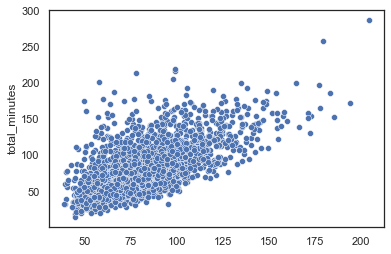

In [13]:
model,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = reg)

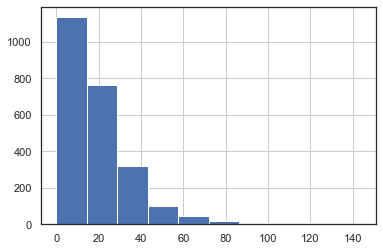

In [14]:
error.hist();

### Using robust scaler on the numeric variables before use SVR

i used this scaler because is robust with outliers

In [15]:
#qt = QuantileTransformer(n_quantiles=10, random_state=0,output_distribution='uniform')
qt = RobustScaler()
cols= ['UN','picking_speed', 'order_stores_distance']
scaled = pd.DataFrame(qt.fit_transform(X_train[cols]),columns=cols, index = X_train.index.values)
print(scaled.shape)
X_train = pd.merge(X_train,scaled,left_index= True , right_index= True, suffixes= ('','_scaled'),how='left')
X_train.drop(cols, axis=1, inplace=True)
print(X_train .shape)
scaled = pd.DataFrame(qt.transform(X_test[cols]),columns=cols, index = X_test.index.values)
print(scaled.shape)
X_test = pd.merge(X_test,scaled,left_index= True , right_index= True, suffixes= ('','_scaled'),how='left')
X_test.drop(cols, axis=1, inplace=True)
print(X_test .shape)

(5588, 3)
(5588, 9)
(2395, 3)
(2395, 9)


### Suppor vector Regression using non-linear Kernels

<https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html>

#### Train with cross-validation

Mean test R2 of the training with cross validation: 0.449 (0.043)
Mean test MSE of the training with cross validation: -666.356 (65.864)
Mean test MAE of the training with cross validation: -18.615 (0.549)


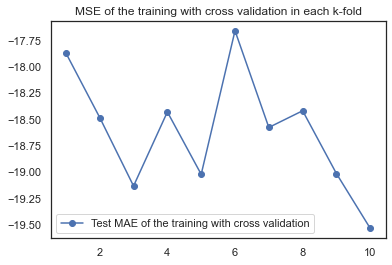

In [16]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
scores_rbf = train_metrics(X = X_train,y = y_train,n_cv=10, metrics = metrics, model = svr_rbf)

#### Train model and predict on the test data to report metrics

-1.7717275796490926
The mean squared error (MSE) on test set: 681.0158
The mean absolute error (MAE) on test set: 18.9589
count    2395.000000
mean       18.958922
std        17.936259
min         0.022738
25%         6.792136
50%        14.406990
75%        25.099243
max       150.001575
Name: total_minutes, dtype: float64


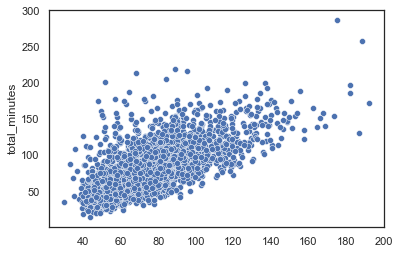

In [17]:
model,y_pred, error = show_test_metrics(X_train,y_train,y_test,model = svr_rbf)

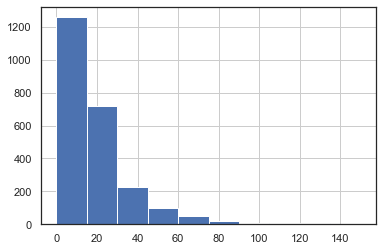

In [18]:
error.hist();